In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Statistics

include("../helpers.jl");
# include("../scalers.jl")
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_2_df, y_2_df = readjsonsfromdirectory(target_directory, x_df, y_df);
x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [4]:
# decorrelate x_df
function dynamicscale(data_raw, dynamic_lower, upper)
    return (data_raw .- dynamic_lower) ./ (upper .- dynamic_lower)
end

max_dvar_3 = 160
eta_3 = 10.
max_dvar_5 = 1.85
eta_5 = 0.05
max_dvar_12 = 2.0
eta_12 = 0.05
max_dvar_9 = -25.
eta_9 = 2.5
max_dvar_13 = -20.
eta_13 = 2.5

dvar_3_prime = dynamicscale(x_df[:, "DVAR3"], eta_3 .+ x_df[:, "DVAR2"], max_dvar_3)
dvar_5_prime = dynamicscale(x_df[:, "DVAR5"], x_df[:, "DVAR4"] .+ eta_5, max_dvar_5)
dvar_12_prime = dynamicscale(x_df[:, "DVAR12"], x_df[:, "DVAR5"] .+ eta_12, max_dvar_12)
dvar_9_prime = dynamicscale(x_df[:, "DVAR9"], x_df[:, "DVAR8"] .+ eta_9, max_dvar_9)
dvar_13_prime = dynamicscale(x_df[:, "DVAR13"], x_df[:, "DVAR9"] .+ eta_13, max_dvar_13)

x_2_df[:, "DVAR3"] = dvar_3_prime;
x_2_df[:, "DVAR5"] = dvar_5_prime;
x_2_df[:, "DVAR12"] = dvar_12_prime;
x_2_df[:, "DVAR9"] = dvar_9_prime;
x_2_df[:, "DVAR13"] = dvar_13_prime;

In [5]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)[1]
x_dynamically_scaled_df = minmaxscaledf(x_2_df)[1]
y_scaled_df = minmaxscaledf(y_df)[1]

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

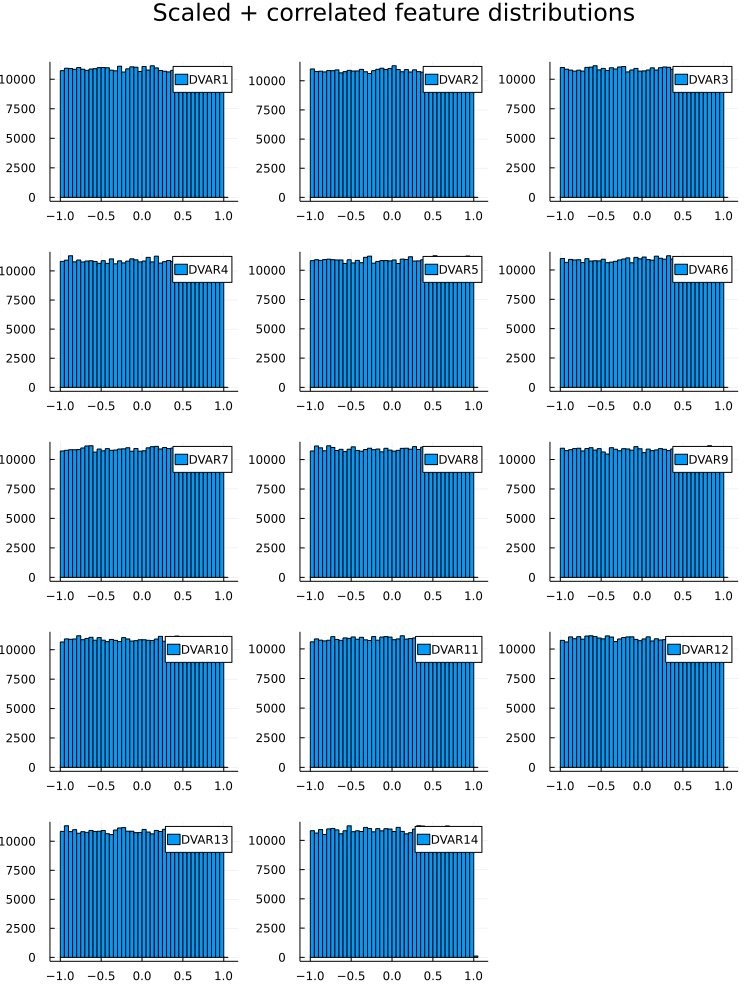

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled + correlated feature distributions")

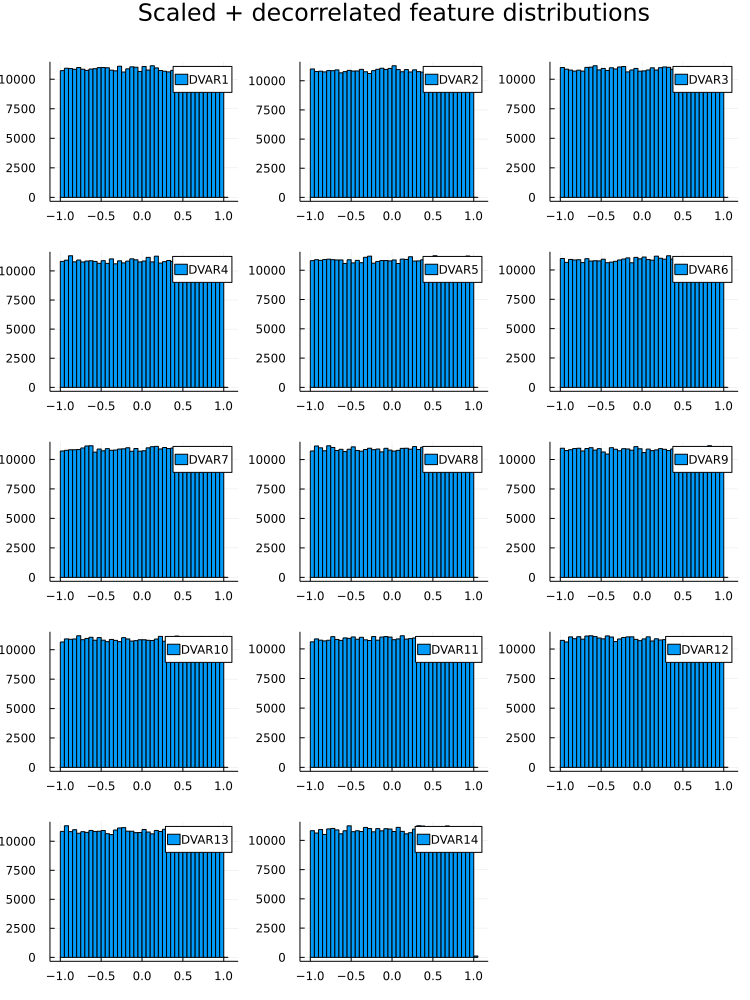

In [7]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_dynamically_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled + decorrelated feature distributions")

In [8]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];

x_train_decorr_df = x_dynamically_scaled_df[train_indexes, :];
x_test_decorr_df = x_dynamically_scaled_df[test_indexes, :];

y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [9]:
# format to arrays
x_train = Float64.(Matrix(x_train_df)); x_test = Float64.(Matrix(x_test_df));
x_train_decorr = Float64.(Matrix(x_train_decorr_df)); x_test_decorr = Float64.(Matrix(x_test_decorr_df));
y_train = Float64.(Matrix(y_train_df)); y_test = Float64.(Matrix(y_test_df));

In [10]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [11]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [12]:
# organizing data into batches
batch_size = 256
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [13]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 1500
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=18.26518737510434
epoch 2, loss=14.038715249271435
epoch 3, loss=12.630839785605433
epoch 4, loss=11.75980545278694
epoch 5, loss=11.328882201428092
epoch 6, loss=11.05147987587047
epoch 7, loss=10.637252295113136
epoch 8, loss=10.13475347705149
epoch 9, loss=10.085197061959878
epoch 10, loss=10.588768569126856
epoch 11, loss=9.776159714778034
epoch 12, loss=9.379741606766832
epoch 13, loss=10.277967436976343
epoch 14, loss=9.684060038478588
epoch 15, loss=9.141769543256803
epoch 16, loss=9.117580418939252
epoch 17, loss=8.904465165230127
epoch 18, loss=9.652612001397555
epoch 19, loss=9.158320868950183
epoch 20, loss=9.295792426268518
epoch 21, loss=8.66212929423254
epoch 22, loss=8.90917955674949
epoch 23, loss=8.731770781560664
epoch 24, loss=8.459472467198681
epoch 25, loss=8.642217186658392
epoch 26, loss=8.90300704991263
epoch 27, loss=8.61497790023171
epoch 28, loss=8.289077567582492
epoch 29, loss=8.200252752686884
epoch 30, loss=8.517318146041593
epoch 31, loss=8

epoch 245, loss=6.920832238850328
epoch 246, loss=7.0364939246691245
epoch 247, loss=6.911969514063439
epoch 248, loss=6.909582933937552
epoch 249, loss=6.901424950667533
epoch 250, loss=6.909397151139675
epoch 251, loss=7.017371040011726
epoch 252, loss=6.869278030094073
epoch 253, loss=6.901345387905459
epoch 254, loss=6.995036923959974
epoch 255, loss=6.946681090282035
epoch 256, loss=6.89446436869757
epoch 257, loss=6.928449409663085
epoch 258, loss=6.891035750210682
epoch 259, loss=6.862344305247308
epoch 260, loss=6.864695199734356
epoch 261, loss=6.9135668156564645
epoch 262, loss=6.863016849531471
epoch 263, loss=6.90208000798884
epoch 264, loss=6.902840241520875
epoch 265, loss=6.99853543869049
epoch 266, loss=6.915222489830056
epoch 267, loss=6.871034782253849
epoch 268, loss=6.918812959457714
epoch 269, loss=6.895271540117154
epoch 270, loss=6.823824560943351
epoch 271, loss=6.873451879729479
epoch 272, loss=6.845912058967802
epoch 273, loss=6.851342599090635
epoch 274, loss

epoch 485, loss=6.554042006979721
epoch 486, loss=6.568200464005061
epoch 487, loss=6.608649648857046
epoch 488, loss=6.635455719427128
epoch 489, loss=6.571466183335402
epoch 490, loss=6.636036355841059
epoch 491, loss=6.533920208852558
epoch 492, loss=6.551797532527984
epoch 493, loss=6.593596462614148
epoch 494, loss=6.541947394653606
epoch 495, loss=6.58760205953129
epoch 496, loss=6.606022103580918
epoch 497, loss=6.560839905547014
epoch 498, loss=6.6530799585570435
epoch 499, loss=6.650962634314477
epoch 500, loss=6.535259588176602
epoch 501, loss=6.643738683003924
epoch 502, loss=6.590357825368116
epoch 503, loss=6.576694183443869
epoch 504, loss=6.544094354884707
epoch 505, loss=6.617824337238831
epoch 506, loss=6.549424102503381
epoch 507, loss=6.547481002769669
epoch 508, loss=6.6019880499454695
epoch 509, loss=6.554747637748018
epoch 510, loss=6.575951614650434
epoch 511, loss=6.542646879255436
epoch 512, loss=6.526307952083769
epoch 513, loss=6.552302537675113
epoch 514, lo

epoch 725, loss=6.430696410648197
epoch 726, loss=6.441389670980916
epoch 727, loss=6.419417408169344
epoch 728, loss=6.453397289604633
epoch 729, loss=6.461214141184219
epoch 730, loss=6.4500054751967175
epoch 731, loss=6.425117603737967
epoch 732, loss=6.39509084253964
epoch 733, loss=6.403577599626811
epoch 734, loss=6.4254090111890045
epoch 735, loss=6.4069098109499665
epoch 736, loss=6.5390488139778205
epoch 737, loss=6.439517396028237
epoch 738, loss=6.445408948854376
epoch 739, loss=6.4297018864032065
epoch 740, loss=6.396531019356133
epoch 741, loss=6.4112614083658
epoch 742, loss=6.392065015542345
epoch 743, loss=6.390709943830681
epoch 744, loss=6.4235755416454685
epoch 745, loss=6.426164422412293
epoch 746, loss=6.4268498058992005
epoch 747, loss=6.486357836637042
epoch 748, loss=6.38834453540407
epoch 749, loss=6.426325512081295
epoch 750, loss=6.396016211243871
epoch 751, loss=6.455541118567714
epoch 752, loss=6.384540742409598
epoch 753, loss=6.375224903033411
epoch 754, 

epoch 965, loss=6.315435608566069
epoch 966, loss=6.33162045975787
epoch 967, loss=6.3820313987865775
epoch 968, loss=6.356669629189417
epoch 969, loss=6.3222594520834985
epoch 970, loss=6.325582974034351
epoch 971, loss=6.32745309279425
epoch 972, loss=6.356711538018684
epoch 973, loss=6.322956140149629
epoch 974, loss=6.332886537906852
epoch 975, loss=6.330019355607487
epoch 976, loss=6.34705044434127
epoch 977, loss=6.350198549668712
epoch 978, loss=6.332469324925347
epoch 979, loss=6.323914876495395
epoch 980, loss=6.3751640754814485
epoch 981, loss=6.328671548434823
epoch 982, loss=6.537431431730631
epoch 983, loss=6.329028574733948
epoch 984, loss=6.3209006586141765
epoch 985, loss=6.345247509903931
epoch 986, loss=6.334331400044328
epoch 987, loss=6.3292863583773435
epoch 988, loss=6.325569408366141
epoch 989, loss=6.3110820498007
epoch 990, loss=6.315153208387766
epoch 991, loss=6.316791273412842
epoch 992, loss=6.3471743381906345
epoch 993, loss=6.448537759835966
epoch 994, lo

epoch 1200, loss=6.330501046003628
epoch 1201, loss=6.2744848673532845
epoch 1202, loss=6.329579368545505
epoch 1203, loss=6.322904411143096
epoch 1204, loss=6.280076299305104
epoch 1205, loss=6.300243369090522
epoch 1206, loss=6.284005206873941
epoch 1207, loss=6.267137897077755
epoch 1208, loss=6.335118710225752
epoch 1209, loss=6.389703754557354
epoch 1210, loss=6.2724597794296795
epoch 1211, loss=6.282600369153305
epoch 1212, loss=6.3254827600125
epoch 1213, loss=6.32613860267109
epoch 1214, loss=6.282973115641341
epoch 1215, loss=6.246887906556031
epoch 1216, loss=6.266648338945026
epoch 1217, loss=6.297345824142617
epoch 1218, loss=6.25326033571449
epoch 1219, loss=6.287009503101002
epoch 1220, loss=6.325476526710876
epoch 1221, loss=6.272862141662207
epoch 1222, loss=6.2731927454164955
epoch 1223, loss=6.341298107371122
epoch 1224, loss=6.302043222094321
epoch 1225, loss=6.326294343273463
epoch 1226, loss=6.297757901386552
epoch 1227, loss=6.308714962379202
epoch 1228, loss=6.27

epoch 1433, loss=6.282210176941272
epoch 1434, loss=6.2562443638215415
epoch 1435, loss=6.243082944077682
epoch 1436, loss=6.249451922470874
epoch 1437, loss=6.321212085662892
epoch 1438, loss=6.249369169777857
epoch 1439, loss=6.323690971914186
epoch 1440, loss=6.237482594911405
epoch 1441, loss=6.268173878598321
epoch 1442, loss=6.222084141937753
epoch 1443, loss=6.227654687837588
epoch 1444, loss=6.26912989438079
epoch 1445, loss=6.269945501355335
epoch 1446, loss=6.253034476252206
epoch 1447, loss=6.245218689882521
epoch 1448, loss=6.227478383606072
epoch 1449, loss=6.239623413904287
epoch 1450, loss=6.246106820830016
epoch 1451, loss=6.227912020145681
epoch 1452, loss=6.297590548384643
epoch 1453, loss=6.32905713975302
epoch 1454, loss=6.206359292633517
epoch 1455, loss=6.238305445252274
epoch 1456, loss=6.239898907885872
epoch 1457, loss=6.296888532953419
epoch 1458, loss=6.236484954121609
epoch 1459, loss=6.312289087823384
epoch 1460, loss=6.2207375821429
epoch 1461, loss=6.3139

In [14]:
# organizing data into batches for decorrelated data
data_decorr_loader = Flux.Data.DataLoader((x_train_decorr', y_train'), batchsize=batch_size, shuffle=true);

In [15]:
# defining our model, optimization algorithm and loss function
m_decorr = neuralnetwork()
loss_decorr(x, y) = Flux.mse(m_decorr(x), y)

# training
training_losses_decorr = Float32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss_decorr, Flux.params(m_decorr), data_decorr_loader, optimizer)
    l = 0.
    for d in data_decorr_loader
        l += loss_decorr(d...)
    end
    println(" loss=$l")
    push!(training_losses_decorr, l)
end

epoch 1, loss=19.780644306757587
epoch 2, loss=14.03810671331063
epoch 3, loss=12.348236907003535
epoch 4, loss=12.304834792196688
epoch 5, loss=11.356144030233791
epoch 6, loss=10.870586315648993
epoch 7, loss=10.34111371243133
epoch 8, loss=10.012406826471368
epoch 9, loss=9.846873187387507
epoch 10, loss=10.468118936542801
epoch 11, loss=9.275727793505931
epoch 12, loss=9.326093449306427
epoch 13, loss=9.206240709573038
epoch 14, loss=8.999785417393397
epoch 15, loss=8.768107530206512
epoch 16, loss=8.892305473787104
epoch 17, loss=8.579853146466606
epoch 18, loss=8.63998848071076
epoch 19, loss=8.668294548250149
epoch 20, loss=8.405217086242125
epoch 21, loss=8.522935557927696
epoch 22, loss=8.537020800086568
epoch 23, loss=8.43402108392712
epoch 24, loss=8.402801697351322
epoch 25, loss=8.692629859964057
epoch 26, loss=8.330136877768078
epoch 27, loss=8.178565744560869
epoch 28, loss=8.33294335950323
epoch 29, loss=8.164729248339174
epoch 30, loss=8.25225354609916
epoch 31, loss=8

epoch 245, loss=6.8889632725817975
epoch 246, loss=6.9206134775956105
epoch 247, loss=6.896863945607394
epoch 248, loss=6.924185338097077
epoch 249, loss=6.896442010452624
epoch 250, loss=6.868733080907384
epoch 251, loss=6.9009109072046355
epoch 252, loss=6.9231674107245595
epoch 253, loss=6.901142613127236
epoch 254, loss=6.875626756780593
epoch 255, loss=6.897290491431759
epoch 256, loss=6.831063927339676
epoch 257, loss=6.840136406613996
epoch 258, loss=6.836965252102642
epoch 259, loss=6.834749127836347
epoch 260, loss=6.838760559607077
epoch 261, loss=6.941826819034412
epoch 262, loss=6.941322572539368
epoch 263, loss=6.879780850368235
epoch 264, loss=6.84264451911599
epoch 265, loss=6.854127548245094
epoch 266, loss=6.897214491541809
epoch 267, loss=6.824207436366055
epoch 268, loss=6.888816598873234
epoch 269, loss=6.922112892135185
epoch 270, loss=6.821534540114764
epoch 271, loss=6.863559917731915
epoch 272, loss=6.868506052088996
epoch 273, loss=6.8497279736898955
epoch 274,

epoch 485, loss=6.68391426318602
epoch 486, loss=6.658999315196594
epoch 487, loss=6.599793515561745
epoch 488, loss=6.57097691502938
epoch 489, loss=6.572614727729319
epoch 490, loss=6.634133305100937
epoch 491, loss=6.573485893250571
epoch 492, loss=6.53926235207226
epoch 493, loss=6.539832323580096
epoch 494, loss=6.603696815386492
epoch 495, loss=6.6262101116586605
epoch 496, loss=6.6072097886478165
epoch 497, loss=6.593797150379551
epoch 498, loss=6.584530100585074
epoch 499, loss=6.555365686244843
epoch 500, loss=6.580816665748913
epoch 501, loss=6.550734429732735
epoch 502, loss=6.6165256050994685
epoch 503, loss=6.546094438311024
epoch 504, loss=6.615936266573494
epoch 505, loss=6.548883865822664
epoch 506, loss=6.561401065102244
epoch 507, loss=6.573010903175639
epoch 508, loss=6.631316938642727
epoch 509, loss=6.573432383778877
epoch 510, loss=6.591876740583443
epoch 511, loss=6.534048195421016
epoch 512, loss=6.525241954558839
epoch 513, loss=6.56670206361238
epoch 514, loss

epoch 726, loss=6.4178772643773705
epoch 727, loss=6.420220205664204
epoch 728, loss=6.4640921956987105
epoch 729, loss=6.436663706788299
epoch 730, loss=6.429774441910974
epoch 731, loss=6.423037010392957
epoch 732, loss=6.418826851828941
epoch 733, loss=6.457391698144789
epoch 734, loss=6.411303606985454
epoch 735, loss=6.416132938939415
epoch 736, loss=6.5198801264010475
epoch 737, loss=6.411652164427336
epoch 738, loss=6.422568617302171
epoch 739, loss=6.389714905196267
epoch 740, loss=6.428375168225169
epoch 741, loss=6.429675207309391
epoch 742, loss=6.483769306940442
epoch 743, loss=6.431993358701108
epoch 744, loss=6.397033083475769
epoch 745, loss=6.405009269197792
epoch 746, loss=6.408805288664326
epoch 747, loss=6.412407517588119
epoch 748, loss=6.484072054888446
epoch 749, loss=6.511784531077957
epoch 750, loss=6.459908916905195
epoch 751, loss=6.422810754157017
epoch 752, loss=6.396329344357083
epoch 753, loss=6.47288147416683
epoch 754, loss=6.430079405230865
epoch 755, l

epoch 967, loss=6.344455115542906
epoch 968, loss=6.357070746777722
epoch 969, loss=6.402358516361159
epoch 970, loss=6.343612902402023
epoch 971, loss=6.3447261294521535
epoch 972, loss=6.584415316421059
epoch 973, loss=6.366358692779689
epoch 974, loss=6.36240928803743
epoch 975, loss=6.383920120988373
epoch 976, loss=6.357646828656949
epoch 977, loss=6.363207180743058
epoch 978, loss=6.3482046716380545
epoch 979, loss=6.3293007508288515
epoch 980, loss=6.321624969870285
epoch 981, loss=6.349240598511596
epoch 982, loss=6.367695019535828
epoch 983, loss=6.297513740648577
epoch 984, loss=6.410418572553488
epoch 985, loss=6.338045400506049
epoch 986, loss=6.389501997094563
epoch 987, loss=6.356556072126877
epoch 988, loss=6.396962068370931
epoch 989, loss=6.33836249289279
epoch 990, loss=6.3428382598513595
epoch 991, loss=6.3615070115181025
epoch 992, loss=6.323652935700457
epoch 993, loss=6.35267561242672
epoch 994, loss=6.304771214960742
epoch 995, loss=6.379517613135474
epoch 996, l

epoch 1202, loss=6.3324726134903875
epoch 1203, loss=6.339728077170863
epoch 1204, loss=6.309502504665428
epoch 1205, loss=6.306311079799925
epoch 1206, loss=6.2699761239035405
epoch 1207, loss=6.286928934897107
epoch 1208, loss=6.337266917905091
epoch 1209, loss=6.301559089170721
epoch 1210, loss=6.359968471973151
epoch 1211, loss=6.3332822698201445
epoch 1212, loss=6.326443804865758
epoch 1213, loss=6.276404334748909
epoch 1214, loss=6.311728962652582
epoch 1215, loss=6.32342266402449
epoch 1216, loss=6.25579313964303
epoch 1217, loss=6.334401068058995
epoch 1218, loss=6.280505031683324
epoch 1219, loss=6.27303350543985
epoch 1220, loss=6.284225165809079
epoch 1221, loss=6.300074021488645
epoch 1222, loss=6.293513848808913
epoch 1223, loss=6.346843245989269
epoch 1224, loss=6.319723817279967
epoch 1225, loss=6.305997131941102
epoch 1226, loss=6.310777009282388
epoch 1227, loss=6.27567371037995
epoch 1228, loss=6.278442465566176
epoch 1229, loss=6.269948513114074
epoch 1230, loss=6.30

epoch 1436, loss=6.2365882851450305
epoch 1437, loss=6.263070495053684
epoch 1438, loss=6.250426532515084
epoch 1439, loss=6.322152116018226
epoch 1440, loss=6.237950926711447
epoch 1441, loss=6.2429929577798715
epoch 1442, loss=6.254971120927264
epoch 1443, loss=6.2844079925692
epoch 1444, loss=6.280751340297486
epoch 1445, loss=6.2631143130100675
epoch 1446, loss=6.287494728600343
epoch 1447, loss=6.29684756461416
epoch 1448, loss=6.296619603450241
epoch 1449, loss=6.252058642981465
epoch 1450, loss=6.264848275667452
epoch 1451, loss=6.243678102115559
epoch 1452, loss=6.259783168791009
epoch 1453, loss=6.230606472570684
epoch 1454, loss=6.250977195543965
epoch 1455, loss=6.301826117702824
epoch 1456, loss=6.261619893615094
epoch 1457, loss=6.259525303916094
epoch 1458, loss=6.2433599439112335
epoch 1459, loss=6.2404293960308745
epoch 1460, loss=6.246137222476771
epoch 1461, loss=6.259482306238717
epoch 1462, loss=6.227959484523058
epoch 1463, loss=6.244822620334043
epoch 1464, loss=6

In [30]:
last(training_losses, 250)

250-element Vector{Float32}:
 6.3109827
 6.2630296
 6.2727675
 6.2602644
 6.296713
 6.293198
 6.294079
 6.3017893
 6.2875047
 6.269313
 6.2947936
 6.2605977
 6.314346
 ⋮
 6.253126
 6.2242246
 6.2531056
 6.2153993
 6.2551484
 6.235542
 6.243898
 6.198248
 6.218153
 6.2705874
 6.2188168
 6.2498517

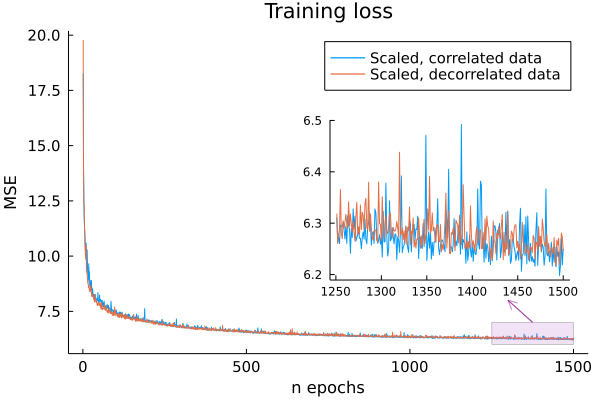

In [100]:
# plot training history
plot(epochs, training_losses;
    title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false,
    label="Scaled, correlated data", dpi=400, grid=false, xtickfontsize=10, ytickfontsize=10, legendfontsize=10)
plot!(epochs, training_losses_decorr; legend=true, label="Scaled, decorrelated data")

# rectangle and arrow
arrow_x = [1375, 1300]
arrow_y = [7, 8]
#GR.setarrowsize(1)
plot!(arrow_x, arrow_y, arrow=true, arrowsize=0.5, label=nothing, color="purple", opacity=0.5)
plot!(Shape([1250, 1500, 1500, 1250], [6, 6, 7, 7]), label=nothing, opacity=0.2)


n_last = 250
plot!(
    last(epochs, n_last), last(training_losses, n_last);
    inset = (bbox(0.05, 0.3, 0.4, 0.4, :bottom, :right)),
    subplot = 2,
    bg_inside = nothing,
    legend = false,
    grid = false,
)
plot!(
    last(epochs, n_last), last(training_losses_decorr, n_last);
    subplot = 2,
    bg_inside = nothing,
)

#savefig("corr_decorr_training.png")

## Model evaluation

In [17]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [18]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.925462330684431
r2 on test set: 0.9281885118018862


In [19]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [20]:
size(x_train, 2)

14

In [21]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9254593290495522
adjustedr2 on test set: 0.9281769430317083


In [22]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.04420318182517241
mae on test set: 0.04456510598068728


In [23]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.01646110192726603
mae on test set for OBJ1: 0.01682296542891321
mae on training set for OBJ2: 0.07404475256232043
mae on test set for OBJ2: 0.07449429659862636
mae on training set for OBJ3: 0.010641337451516741
mae on test set for OBJ3: 0.010728670783514242
mae on training set for OBJ4: 0.006663010158202734
mae on test set for OBJ4: 0.006651719281550631
mae on training set for OBJ5: 0.08091478743345144
mae on test set for OBJ5: 0.08171950598002212
mae on training set for OBJ6: 0.07649410141827702
mae on test set for OBJ6: 0.07697347781149712


In [24]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    minmax_fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_preds_original = minmax_inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = minmax_inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = minmax_inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = minmax_inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

LoadError: UndefVarError: minmax_fit! not defined

In [25]:
i = 7
println("true: ", y_test[i, :])
println("predicted: ", y_test_preds[i, :])

true: [0.6223333674676446, -0.44512203847907283, -0.6124331161634942, -0.9082482694053088, -0.35160857317567695, -0.6217327426228616]
predicted: [0.6401419961980713, -0.4229889765493623, -0.5879092237229343, -0.9168937976657462, -0.4827134690433666, -0.5387832993388806]


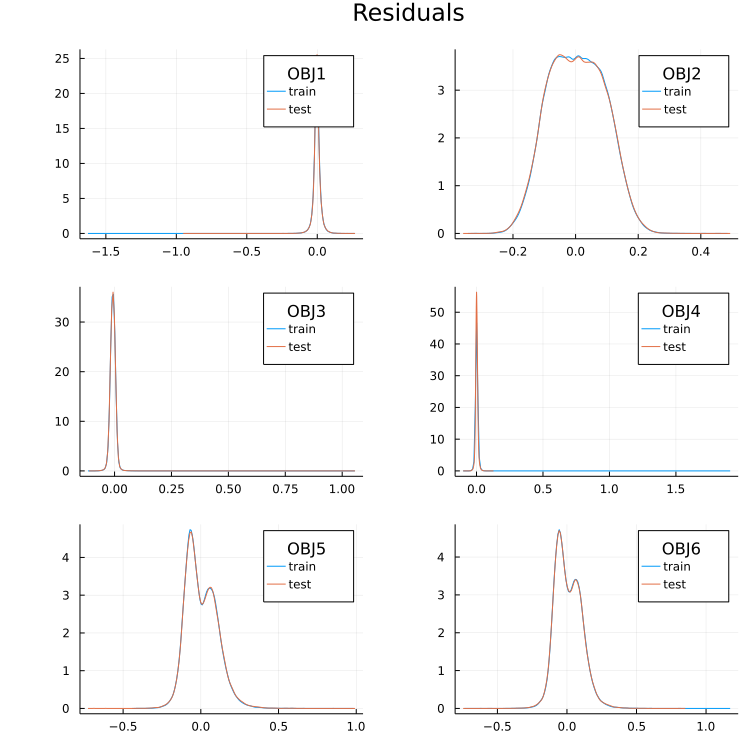

In [26]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

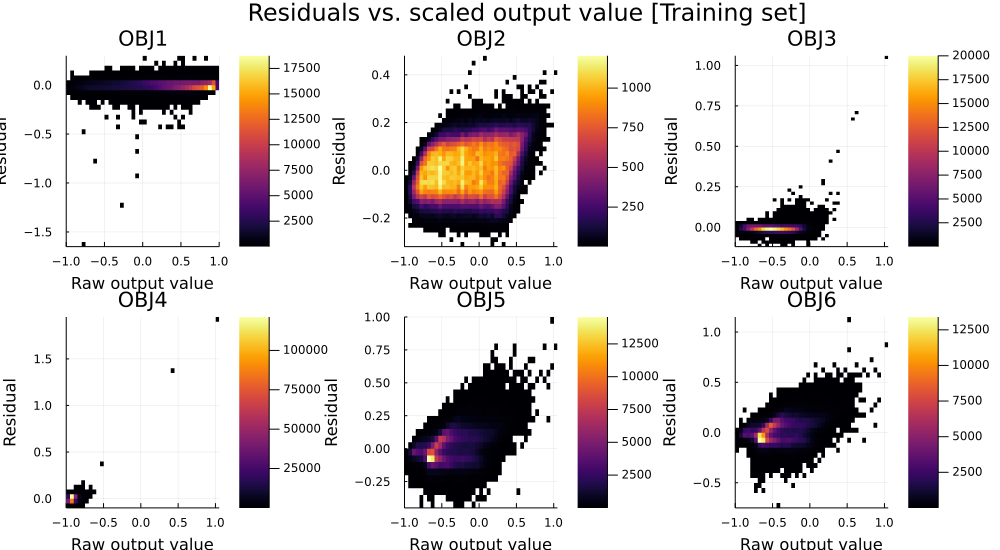

In [27]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

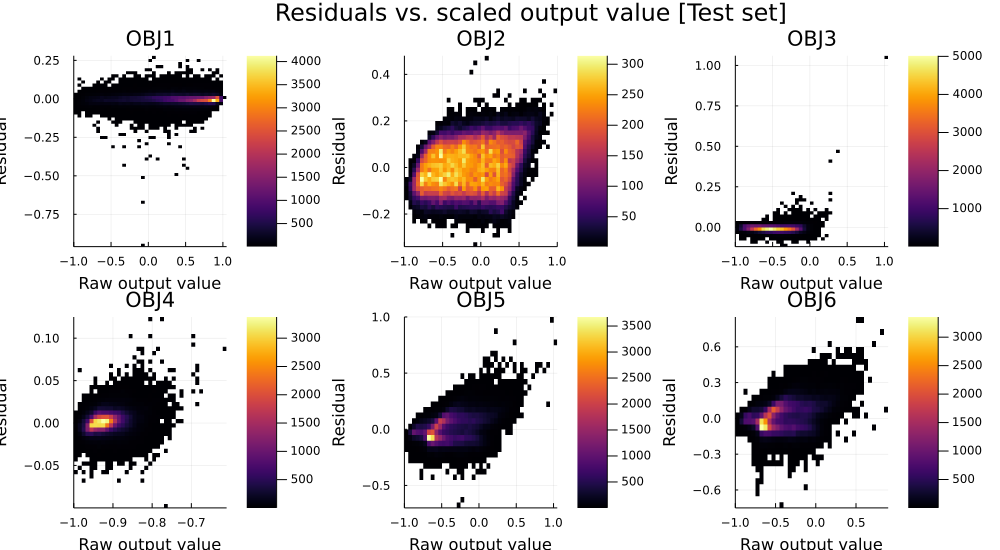

In [28]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")